# Code for writing the lung sound data to .ts file

Below are different approaches to loading the data to a .ts file, so that it can be utilised by sktime

In [1]:
import numpy as np
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
sys.path.insert(1, module_path + '/src/utils/')

import utility

import librosa
import sktime
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sklearn.model_selection import train_test_split

from math import ceil

def znorm(timeseries):
    mean = np.mean(timeseries)
    sd = np.std(timeseries)
    return (timeseries - mean)/sd

target_rate = 44100
ds_target_rate = 8000
AUTH = 'Litt3200'
ESSUA = ['AKGC417L', 'LittC2SE', 'Meditron']


import librosa
from scipy.stats import skew 

def get_features(data, sr):
    sr = sr
    n_mfcc = 30
    ft1 = librosa.feature.mfcc(data, sr = sr, n_mfcc=n_mfcc)
    ft2 = librosa.feature.zero_crossing_rate(data)[0]
    ft3 = librosa.feature.spectral_rolloff(data)[0]
    ft4 = librosa.feature.spectral_centroid(data)[0]
    ft5 = librosa.feature.spectral_contrast(data)[0]
    ft6 = librosa.feature.spectral_bandwidth(data)[0]

    ### Get HOS and simple features 
    ft0_trunc = np.hstack((np.mean(data) , np.std(data), skew(data), np.max(data), np.median(data), np.min(data), utility.get_energy(data), utility.get_entropy(data)))

    ### MFCC features
    ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1)))

    ### Spectral Features 
    ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
    ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
    ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
    ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.median(ft5), np.min(ft5)))
    ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.median(ft6), np.max(ft6)))
    return pd.Series(np.hstack((ft0_trunc , ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc)))


Firstly printing some information to get an understanding of what data is present

In [3]:
none_path = module_path + '/data/kaggle/none/'
crackle_path = module_path + '/data/kaggle/crackle/'
both_path = module_path + '/data/kaggle/both/'
wheeze_path = module_path + '/data/kaggle/wheeze/'


none = [file_name for file_name in os.listdir(none_path) if '.wav' in file_name]
crackle = [file_name for file_name in os.listdir(crackle_path) if '.wav' in file_name]
wheeze = [file_name for file_name in os.listdir(wheeze_path) if '.wav' in file_name]
both= [file_name for file_name in os.listdir(both_path) if '.wav' in file_name]

class_paths = {'crackle' : crackle_path,
    'wheeze': wheeze_path,
    'normal': none_path, 
}

frame_len = round(ds_target_rate*0.002)
print(f'Frame length for calculating rmf: {frame_len}')
hop_len = ceil(frame_len/1.5)
print(f'Hop length for calculating rmf: {hop_len}')

Frame length for calculating rmf: 16
Hop length for calculating rmf: 11


In [64]:
labels = np.hstack([np.repeat('normal', len(none)), np.repeat('crackle', len(crackle)),
                   np.repeat('wheeze', len(wheeze)), np.repeat('both', len(both))])
names = np.hstack([none, crackle, wheeze, both])
ids = np.array([int(name[0:3]) for name in names])

data = pd.DataFrame({
    'name' : names,
    'nr' : ids,
    'label' : labels
})

# Balancing the dataset
indices_1 = np.where(data['label'] == 'normal')[0]
indices_2 = np.where(data['label'] == 'crackle')[0]
indices_3 = np.where(data['label'] == 'wheeze')[0]

np.random.seed(0)
np.random.shuffle(indices_1)
np.random.shuffle(indices_2)
indices_new = np.concatenate((indices_1[0:1000], indices_2[0:1000], indices_3))

# Making sure that no same patient appears both in training and test set
new_dataset = data.iloc[indices_new].copy()
id_unique = id_unique = new_dataset['nr'].unique()

id_train , id_test = train_test_split(id_unique, test_size=0.2, random_state=42)
id_train , id_val = train_test_split(id_train, test_size=0.25, random_state=42)


new_dataset = new_dataset.reset_index(drop = True)


def get_indices(id_list, data):
    indices = np.array([])
    for i in id_list:
        idx = np.where(data['nr'] == i)[0]
        indices = np.append([list(idx)] , [indices])
    return indices

indices_train = get_indices(id_train, new_dataset).astype(int)
indices_test = get_indices(id_test, new_dataset).astype(int)
indices_val = get_indices(id_val, new_dataset).astype(int)

In [68]:
file_splits = {
    '/features/extracted_features_ts_files/kaggle_TRAIN.ts' : indices_train,
    '/features/extracted_features_ts_files/kaggle_TEST.ts' : indices_test,
    '/features/extracted_features_ts_files/kaggle_VAL.ts' : indices_val
    
}

LITTMANN = ['Litt3200', 'LittC2SE']

def write_feature_extracted_dataset_to_ts(filename, data):

    w = open(module_path + filename, 'w+')
    row = w.read()

    w.write('@problemName Kaggle_lung_sound \n')
    w.write('@timeStamps false \n')
    w.write('@missing false \n')
    w.write('@univariate true \n')
    w.write('@equalLength true \n')
    w.write('@classLabel true normal crackle wheeze \n')
    w.write('@data \n')

    error_in_data = {}
    count = 0
    for row in data.iterrows():
        label = row[1]['label']
        audio_file = class_paths[label] + row[1]['name']
        
        rec_met = name[14:22]
        #if rec_met in LITTMANN:
        try:
            sr, audio = utility.read_wav_file(audio_file, target_rate)

        except EOFError as error:
            error_in_data[audio_file] = 'EOFError'
            continue

        try:
            audio = utility.denoise_audio(audio)
            audio, sr = utility.downsample(audio, sr, 8000), 8000
    
            audio = znorm(audio)
            audio = get_features(audio, sr)
            
            new_row = str(list(audio))[1:-1].replace(' ', '') + ':' + label + '\n'
            w.write(new_row)

            print(f'Extracting file : {count}, of totally {len(data)}')    
            count = count + 1

        except ValueError as error:
            error_in_data[audio_file] = 'ValueError'
            continue
    return error_in_data
            
errors = {k : [] for k,v in file_splits.items()}            
for name, i in file_splits.items():
    error = write_feature_extracted_dataset_to_ts(name, new_dataset.iloc[i])
    errors[name] = error

Extracting file : 0, of totally 1418
Extracting file : 1, of totally 1418
Extracting file : 2, of totally 1418
Extracting file : 3, of totally 1418
Extracting file : 4, of totally 1418
Extracting file : 5, of totally 1418
Extracting file : 6, of totally 1418
Extracting file : 7, of totally 1418
Extracting file : 8, of totally 1418
Extracting file : 9, of totally 1418
Extracting file : 10, of totally 1418
Extracting file : 11, of totally 1418
Extracting file : 12, of totally 1418
Extracting file : 13, of totally 1418
Extracting file : 14, of totally 1418
Extracting file : 15, of totally 1418
Extracting file : 16, of totally 1418
Extracting file : 17, of totally 1418
Extracting file : 18, of totally 1418
Extracting file : 19, of totally 1418
Extracting file : 20, of totally 1418
Extracting file : 21, of totally 1418
Extracting file : 22, of totally 1418
Extracting file : 23, of totally 1418
Extracting file : 24, of totally 1418
Extracting file : 25, of totally 1418
Extracting file : 26, 

Extracting file : 215, of totally 1418
Extracting file : 216, of totally 1418
Extracting file : 217, of totally 1418
Extracting file : 218, of totally 1418
Extracting file : 219, of totally 1418
Extracting file : 220, of totally 1418
Extracting file : 221, of totally 1418
Extracting file : 222, of totally 1418
Extracting file : 223, of totally 1418
Extracting file : 224, of totally 1418
Extracting file : 225, of totally 1418
Extracting file : 226, of totally 1418
Extracting file : 227, of totally 1418
Extracting file : 228, of totally 1418
Extracting file : 229, of totally 1418
Extracting file : 230, of totally 1418
Extracting file : 231, of totally 1418
Extracting file : 232, of totally 1418
Extracting file : 233, of totally 1418
Extracting file : 234, of totally 1418
Extracting file : 235, of totally 1418
Extracting file : 236, of totally 1418
Extracting file : 237, of totally 1418
Extracting file : 238, of totally 1418
Extracting file : 239, of totally 1418
Extracting file : 240, of

Extracting file : 426, of totally 1418
Extracting file : 427, of totally 1418
Extracting file : 428, of totally 1418
Extracting file : 429, of totally 1418
Extracting file : 430, of totally 1418
Extracting file : 431, of totally 1418


/home/andrine/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1824
  n_fft, y.shape[-1]


Extracting file : 432, of totally 1418
Extracting file : 433, of totally 1418
Extracting file : 434, of totally 1418
Extracting file : 435, of totally 1418
Extracting file : 436, of totally 1418
Extracting file : 437, of totally 1418
Extracting file : 438, of totally 1418
Extracting file : 439, of totally 1418
Extracting file : 440, of totally 1418
Extracting file : 441, of totally 1418
Extracting file : 442, of totally 1418
Extracting file : 443, of totally 1418
Extracting file : 444, of totally 1418
Extracting file : 445, of totally 1418
Extracting file : 446, of totally 1418
Extracting file : 447, of totally 1418
Extracting file : 448, of totally 1418
Extracting file : 449, of totally 1418
Extracting file : 450, of totally 1418
Extracting file : 451, of totally 1418
Extracting file : 452, of totally 1418
Extracting file : 453, of totally 1418
Extracting file : 454, of totally 1418
Extracting file : 455, of totally 1418
Extracting file : 456, of totally 1418
Extracting file : 457, of

Extracting file : 645, of totally 1418
Extracting file : 646, of totally 1418
Extracting file : 647, of totally 1418
Extracting file : 648, of totally 1418
Extracting file : 649, of totally 1418
Extracting file : 650, of totally 1418
Extracting file : 651, of totally 1418
Extracting file : 652, of totally 1418
Extracting file : 653, of totally 1418
Extracting file : 654, of totally 1418
Extracting file : 655, of totally 1418
Extracting file : 656, of totally 1418
Extracting file : 657, of totally 1418
Extracting file : 658, of totally 1418
Extracting file : 659, of totally 1418
Extracting file : 660, of totally 1418
Extracting file : 661, of totally 1418
Extracting file : 662, of totally 1418
Extracting file : 663, of totally 1418
Extracting file : 664, of totally 1418
Extracting file : 665, of totally 1418
Extracting file : 666, of totally 1418
Extracting file : 667, of totally 1418
Extracting file : 668, of totally 1418
Extracting file : 669, of totally 1418
Extracting file : 670, of

Extracting file : 856, of totally 1418
Extracting file : 857, of totally 1418
Extracting file : 858, of totally 1418
Extracting file : 859, of totally 1418
Extracting file : 860, of totally 1418
Extracting file : 861, of totally 1418
Extracting file : 862, of totally 1418
Extracting file : 863, of totally 1418
Extracting file : 864, of totally 1418
Extracting file : 865, of totally 1418
Extracting file : 866, of totally 1418
Extracting file : 867, of totally 1418
Extracting file : 868, of totally 1418
Extracting file : 869, of totally 1418
Extracting file : 870, of totally 1418
Extracting file : 871, of totally 1418
Extracting file : 872, of totally 1418
Extracting file : 873, of totally 1418
Extracting file : 874, of totally 1418
Extracting file : 875, of totally 1418
Extracting file : 876, of totally 1418
Extracting file : 877, of totally 1418
Extracting file : 878, of totally 1418
Extracting file : 879, of totally 1418
Extracting file : 880, of totally 1418
Extracting file : 881, of

Extracting file : 1067, of totally 1418
Extracting file : 1068, of totally 1418
Extracting file : 1069, of totally 1418
Extracting file : 1070, of totally 1418
Extracting file : 1071, of totally 1418
Extracting file : 1072, of totally 1418
Extracting file : 1073, of totally 1418
Extracting file : 1074, of totally 1418
Extracting file : 1075, of totally 1418
Extracting file : 1076, of totally 1418
Extracting file : 1077, of totally 1418
Extracting file : 1078, of totally 1418
Extracting file : 1079, of totally 1418
Extracting file : 1080, of totally 1418
Extracting file : 1081, of totally 1418
Extracting file : 1082, of totally 1418
Extracting file : 1083, of totally 1418
Extracting file : 1084, of totally 1418
Extracting file : 1085, of totally 1418
Extracting file : 1086, of totally 1418
Extracting file : 1087, of totally 1418
Extracting file : 1088, of totally 1418
Extracting file : 1089, of totally 1418
Extracting file : 1090, of totally 1418
Extracting file : 1091, of totally 1418


Extracting file : 1273, of totally 1418
Extracting file : 1274, of totally 1418
Extracting file : 1275, of totally 1418
Extracting file : 1276, of totally 1418
Extracting file : 1277, of totally 1418
Extracting file : 1278, of totally 1418
Extracting file : 1279, of totally 1418
Extracting file : 1280, of totally 1418
Extracting file : 1281, of totally 1418
Extracting file : 1282, of totally 1418
Extracting file : 1283, of totally 1418
Extracting file : 1284, of totally 1418
Extracting file : 1285, of totally 1418
Extracting file : 1286, of totally 1418
Extracting file : 1287, of totally 1418
Extracting file : 1288, of totally 1418
Extracting file : 1289, of totally 1418
Extracting file : 1290, of totally 1418
Extracting file : 1291, of totally 1418
Extracting file : 1292, of totally 1418
Extracting file : 1293, of totally 1418
Extracting file : 1294, of totally 1418
Extracting file : 1295, of totally 1418
Extracting file : 1296, of totally 1418
Extracting file : 1297, of totally 1418


Extracting file : 65, of totally 730
Extracting file : 66, of totally 730
Extracting file : 67, of totally 730
Extracting file : 68, of totally 730
Extracting file : 69, of totally 730
Extracting file : 70, of totally 730
Extracting file : 71, of totally 730
Extracting file : 72, of totally 730
Extracting file : 73, of totally 730
Extracting file : 74, of totally 730
Extracting file : 75, of totally 730
Extracting file : 76, of totally 730
Extracting file : 77, of totally 730
Extracting file : 78, of totally 730
Extracting file : 79, of totally 730
Extracting file : 80, of totally 730
Extracting file : 81, of totally 730
Extracting file : 82, of totally 730
Extracting file : 83, of totally 730
Extracting file : 84, of totally 730
Extracting file : 85, of totally 730
Extracting file : 86, of totally 730
Extracting file : 87, of totally 730
Extracting file : 88, of totally 730
Extracting file : 89, of totally 730
Extracting file : 90, of totally 730
Extracting file : 91, of totally 730
E

Extracting file : 284, of totally 730
Extracting file : 285, of totally 730
Extracting file : 286, of totally 730
Extracting file : 287, of totally 730
Extracting file : 288, of totally 730
Extracting file : 289, of totally 730
Extracting file : 290, of totally 730
Extracting file : 291, of totally 730
Extracting file : 292, of totally 730
Extracting file : 293, of totally 730
Extracting file : 294, of totally 730
Extracting file : 295, of totally 730
Extracting file : 296, of totally 730
Extracting file : 297, of totally 730
Extracting file : 298, of totally 730
Extracting file : 299, of totally 730
Extracting file : 300, of totally 730
Extracting file : 301, of totally 730
Extracting file : 302, of totally 730
Extracting file : 303, of totally 730
Extracting file : 304, of totally 730
Extracting file : 305, of totally 730
Extracting file : 306, of totally 730
Extracting file : 307, of totally 730
Extracting file : 308, of totally 730
Extracting file : 309, of totally 730
Extracting f

Extracting file : 502, of totally 730
Extracting file : 503, of totally 730
Extracting file : 504, of totally 730
Extracting file : 505, of totally 730
Extracting file : 506, of totally 730
Extracting file : 507, of totally 730
Extracting file : 508, of totally 730
Extracting file : 509, of totally 730
Extracting file : 510, of totally 730
Extracting file : 511, of totally 730
Extracting file : 512, of totally 730
Extracting file : 513, of totally 730
Extracting file : 514, of totally 730
Extracting file : 515, of totally 730
Extracting file : 516, of totally 730
Extracting file : 517, of totally 730
Extracting file : 518, of totally 730
Extracting file : 519, of totally 730
Extracting file : 520, of totally 730
Extracting file : 521, of totally 730
Extracting file : 522, of totally 730
Extracting file : 523, of totally 730
Extracting file : 524, of totally 730
Extracting file : 525, of totally 730
Extracting file : 526, of totally 730
Extracting file : 527, of totally 730
Extracting f

Extracting file : 719, of totally 730
Extracting file : 720, of totally 730
Extracting file : 721, of totally 730
Extracting file : 722, of totally 730
Extracting file : 723, of totally 730
Extracting file : 724, of totally 730
Extracting file : 725, of totally 730
Extracting file : 726, of totally 730
Extracting file : 727, of totally 730
Extracting file : 728, of totally 730
Extracting file : 729, of totally 730
Extracting file : 0, of totally 738
Extracting file : 1, of totally 738
Extracting file : 2, of totally 738
Extracting file : 3, of totally 738
Extracting file : 4, of totally 738
Extracting file : 5, of totally 738
Extracting file : 6, of totally 738
Extracting file : 7, of totally 738
Extracting file : 8, of totally 738
Extracting file : 9, of totally 738
Extracting file : 10, of totally 738
Extracting file : 11, of totally 738
Extracting file : 12, of totally 738
Extracting file : 13, of totally 738
Extracting file : 14, of totally 738
Extracting file : 15, of totally 738


Extracting file : 209, of totally 738
Extracting file : 210, of totally 738
Extracting file : 211, of totally 738
Extracting file : 212, of totally 738
Extracting file : 213, of totally 738
Extracting file : 214, of totally 738
Extracting file : 215, of totally 738
Extracting file : 216, of totally 738
Extracting file : 217, of totally 738
Extracting file : 218, of totally 738
Extracting file : 219, of totally 738
Extracting file : 220, of totally 738
Extracting file : 221, of totally 738
Extracting file : 222, of totally 738
Extracting file : 223, of totally 738
Extracting file : 224, of totally 738
Extracting file : 225, of totally 738
Extracting file : 226, of totally 738
Extracting file : 227, of totally 738
Extracting file : 228, of totally 738
Extracting file : 229, of totally 738
Extracting file : 230, of totally 738
Extracting file : 231, of totally 738
Extracting file : 232, of totally 738
Extracting file : 233, of totally 738
Extracting file : 234, of totally 738
Extracting f

Extracting file : 426, of totally 738
Extracting file : 427, of totally 738
Extracting file : 428, of totally 738
Extracting file : 429, of totally 738
Extracting file : 430, of totally 738
Extracting file : 431, of totally 738
Extracting file : 432, of totally 738
Extracting file : 433, of totally 738
Extracting file : 434, of totally 738
Extracting file : 435, of totally 738
Extracting file : 436, of totally 738
Extracting file : 437, of totally 738
Extracting file : 438, of totally 738
Extracting file : 439, of totally 738
Extracting file : 440, of totally 738
Extracting file : 441, of totally 738
Extracting file : 442, of totally 738
Extracting file : 443, of totally 738
Extracting file : 444, of totally 738
Extracting file : 445, of totally 738
Extracting file : 446, of totally 738
Extracting file : 447, of totally 738
Extracting file : 448, of totally 738
Extracting file : 449, of totally 738
Extracting file : 450, of totally 738
Extracting file : 451, of totally 738
Extracting f

Extracting file : 643, of totally 738
Extracting file : 644, of totally 738
Extracting file : 645, of totally 738
Extracting file : 646, of totally 738
Extracting file : 647, of totally 738
Extracting file : 648, of totally 738
Extracting file : 649, of totally 738
Extracting file : 650, of totally 738
Extracting file : 651, of totally 738
Extracting file : 652, of totally 738
Extracting file : 653, of totally 738
Extracting file : 654, of totally 738
Extracting file : 655, of totally 738
Extracting file : 656, of totally 738
Extracting file : 657, of totally 738
Extracting file : 658, of totally 738
Extracting file : 659, of totally 738
Extracting file : 660, of totally 738
Extracting file : 661, of totally 738
Extracting file : 662, of totally 738
Extracting file : 663, of totally 738
Extracting file : 664, of totally 738
Extracting file : 665, of totally 738
Extracting file : 666, of totally 738
Extracting file : 667, of totally 738
Extracting file : 668, of totally 738
Extracting f

# OLD cells for writing to ts file


### Zero padding to get equal lengths

AKGC417L


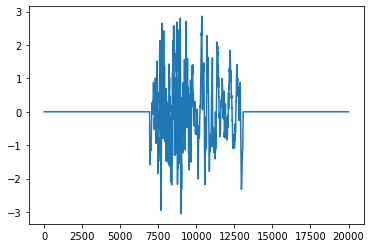

In [7]:
class_list =  ['crackle', 'wheeze', 'none', 'both']
count = 0
import matplotlib.pyplot as plt
for class_ in class_list:
    for name in class_lists[class_]: 
        rec_met = name[14:22]
        print(rec_met)
        if rec_met == AUTH:
            count = count + 1
        audio_file = class_paths[class_] + name
        sr, audio = utility.read_wav_file(audio_file, target_rate)
        audio = utility.denoise_audio(audio)
        audio, sr = utility.downsample(audio, sr, 4000)
        audio = znorm(audio)
        audio = zero_pad(audio, 20000)
        plt.plot(audio)
        break
    break
        


# Creating the .ts file for the four class classification problem

classes: 
   0: crackle
   1: wheeze
   2: none 
   3: both
   
Below the rms of frames are calculated, to compress the data. 

In [160]:
def write_class(writer, class_list, class_name, class_path, fixed= True, fixed_len = 2000):
    classes = {
    'crackle': '0',
    'wheeze': '1',
    'none': '2',
    'both': '3'
    }
    for name in class_list: 
        id_ = name[0:3]
        audio_file = class_path + name
        sr, audio = utility.read_wav_file(audio_file, target_rate)
        audio = utility.denoise_audio(audio)
        audio, sr = utility.downsample(audio, sr, 4000)
        audio = znorm(audio)
        rms_new = librosa.feature.rms(audio, frame_length = frame_len, hop_length = hop_len)[0]
        
        if fixed: 
            if len(rms_new) > fixed_len:
                    rms_new = rms_new[0:fixed_len]
            df_new = np.zeros(fixed_len)
            df_new[0:len(rms_new)] = rms_new
            new_row = str(list(df_new))[1:-1].replace(' ', '') + ':' + classes[class_name] + '\n'
        else: 
            new_row = str(list(rms_new))[1:-1].replace(' ', '') + ':' + classes[class_name] + '\n'
        writer.write(new_row)

def write_ts(filename, fixed = True, fixed_len = 2000):
    w = open(filename, 'w+')
    row = w.read()

    w.write('@problemName LungSounds \n')
    w.write('@timeStamps false \n')
    w.write('@missing false \n')
    w.write('@univariate true \n')
    if fixed: 
        w.write('@equalLength true \n')
        w.write(f'@seriesLength {str(fixed_len)} \n')
    else:
        w.write('@equalLength false \n')
    w.write('@classLabel true crackle wheeze none both \n')
    w.write('@data \n')

    for class_name, class_list in class_lists.items():
        if fixed:
            write_class(w , class_list, class_name, class_paths[class_name], True, fixed_len)
        else: 
            write_class(w , class_list, class_name, class_paths[class_name], False)
    #os.close()

In [161]:
#write_ts(module_path + '/data/ts_files/crackleWheeze.ts', False)

# Creating the .ts files for the two class classification problem
Below the rms of frames are calculated, to compress the data. 

In [11]:
def write_class2(writer, class_list, class_name, class_path, fixed= True, fixed_len = 2000):
    classes = {
    'crackle': '1',
    'wheeze': '0',
    'none': '0',
    'both': '1'
    }
    for name in class_list: 
        audio_file = class_path + name
        sr, audio = utility.read_wav_file(audio_file, target_rate)
        audio = utility.denoise_audio(audio)
        audio, sr = utility.downsample(audio, sr, 4000)
        audio = znorm(audio)
        rms_new = librosa.feature.rms(audio, frame_length = frame_len, hop_length = hop_len)[0]
        
        if fixed: 
            if len(rms_new) > fixed_len:
                    rms_new = rms_new[0:fixed_len]
            df_new = np.zeros(fixed_len)
            df_new[0:len(rms_new)] = rms_new
            new_row = str(list(df_new))[1:-1].replace(' ', '') + ':' + classes[class_name] + '\n'
        else: 
            new_row = str(list(rms_new))[1:-1].replace(' ', '') + ':' + classes[class_name] + '\n'
        writer.write(new_row)

def write_ts2(filename, fixed = True, fixed_len = 2000):
    w = open(filename, 'w+')
    row = w.read()

    w.write('@problemName LungSounds \n')
    w.write('@timeStamps false \n')
    w.write('@missing false \n')
    w.write('@univariate true \n')
    if fixed: 
        w.write('@equalLength true \n')
        w.write(f'@seriesLength {str(fixed_len)} \n')
    else:
        w.write('@equalLength false \n')
    w.write('@classLabel true no_crackle crackle\n')
    w.write('@data \n')

    for class_name, class_list in class_lists.items():
        if fixed:
            write_class2(w , class_list, class_name, class_paths[class_name], True, fixed_len)
        else: 
            write_class2(w , class_list, class_name, class_paths[class_name], False)
    #os.close()

In [12]:
write_ts2(module_path + '/data/ts_files/crackleNoCrackleSamleLength3000.ts', True, 3000)

# Creating the .ts file based on the entire timeseries (no rms compression)

Below the entire timeseries is written to the .ts file. The timeseries that are longer than 5 seconds are discarded to begin with. 
Zero padding is utilised to make catch22 happy

In [12]:
def zero_pad(ts, fixed_len):
    df_new = np.zeros(fixed_len)
    len_ts = len(ts)
    pad = (fixed_len - len_ts)//2
    df_new[pad:pad + len_ts] = ts
    return df_new



def write_class2(writer, class_list, class_name, class_path, fixed_len = 20000):
    classes = {
    'crackle': '1',
    'wheeze': '0',
    'none': '0',
    'both': '1'
    }
    for name in class_list: 
        audio_file = class_path + name
        sr, audio = utility.read_wav_file(audio_file, target_rate)
        audio = utility.denoise_audio(audio)
        audio, sr = utility.downsample(audio, sr, 4000)
        #audio = znorm(audio)
        if len(audio) > fixed_len:
                continue
        else: 
            df_new = zero_pad(audio, fixed_len)
            new_row = str(list(df_new))[1:-1].replace(' ', '') + ':' + classes[class_name] + '\n'
            writer.write(new_row)

def write_ts2(filename, fixed_len = 20000):
    w = open(filename, 'w+')
    row = w.read()

    w.write('@problemName LungSounds \n')
    w.write('@timeStamps false \n')
    w.write('@missing false \n')
    w.write('@univariate true \n')
    w.write('@equalLength true \n')
    w.write(f'@seriesLength {str(fixed_len)} \n')
    w.write('@classLabel true no_crackle crackle\n')
    w.write('@data \n')

    for class_name, class_list in class_lists.items():
        write_class2(w , class_list, class_name, class_paths[class_name])

In [13]:
write_ts2(module_path + '/data/ts_files/crackleNoCrackle_no_rms.ts', fixed_len = 20000)

No zero-padding inequal length 

# Creating .ts file for two class problem

with seperate train and test set based on the recording institution

Below the rms of frames are calculated, to compress the data. 

In [8]:
AUTH = 'Litt3200'
ESSUA = ['AKGC417L', 'LittC2SE', 'Meditron']

def write_class_separate_loc(writer, class_list, class_name, class_path, fixed= True, fixed_len = 2000):
    classes = {
    'crackle': '1',
    'wheeze': '0',
    'none': '0',
    'both': '1'
    }
    for name in class_list: 
        rec_met = name[14:22]
        if rec_met == AUTH:
            audio_file = class_path + name
            sr, audio = utility.read_wav_file(audio_file, target_rate)
            audio = utility.denoise_audio(audio)
            audio, sr = utility.downsample(audio, sr, 4000)
            audio = znorm(audio)
            rms_new = librosa.feature.rms(audio, frame_length = frame_len, hop_length = hop_len)[0]

            if fixed: 
                if len(rms_new) > fixed_len:
                        rms_new = rms_new[0:fixed_len]
                df_new = np.zeros(fixed_len)
                df_new[0:len(rms_new)] = rms_new
                new_row = str(list(df_new))[1:-1].replace(' ', '') + ':' + classes[class_name] + '\n'
            else: 
                new_row = str(list(rms_new))[1:-1].replace(' ', '') + ':' + classes[class_name] + '\n'
            writer.write(new_row)

def write_ts_separate_loc(filename, fixed = True, fixed_len = 2000):
    w = open(filename, 'w+')
    row = w.read()

    w.write('@problemName LungSounds \n')
    w.write('@timeStamps false \n')
    w.write('@missing false \n')
    w.write('@univariate true \n')
    if fixed: 
        w.write('@equalLength true \n')
        w.write(f'@seriesLength {str(fixed_len)} \n')
    else:
        w.write('@equalLength false \n')
    w.write('@classLabel true crackle no_crackle \n')
    w.write('@data \n')

    for class_name, class_list in class_lists.items():
        if fixed:
            write_class2(w , class_list, class_name, class_paths[class_name], True, fixed_len)
        else: 
            write_class2(w , class_list, class_name, class_paths[class_name], False)
    #os.close()
    
    
write_ts_separate_loc(module_path + '/data/ts_files/crackleNoCrackle_3000_same_AUTH.ts', True, 3000)